In [1]:
# Lib Imports
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression, LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import category_encoders as ce

In [2]:
# Setting Pandas column display option
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
%%time
idee = pd.read_csv('train_identity.csv')
transaction = pd.read_csv('train_transaction.csv')

Wall time: 17.1 s


In [4]:
%%time
def pipeline(idee, transaction):
    merge = transaction.merge(idee, how='outer', on='TransactionID')
    objects = merge.select_dtypes('object')
    objects['isFraud'] = merge['isFraud']
    objects.fillna("Unknown", inplace=True)
    objects = objects.astype('category')
    print(objects.info())
    return objects
objects = pipeline(idee,transaction)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   ProductCD      590540 non-null  category
 1   card4          590540 non-null  category
 2   card6          590540 non-null  category
 3   P_emaildomain  590540 non-null  category
 4   R_emaildomain  590540 non-null  category
 5   M1             590540 non-null  category
 6   M2             590540 non-null  category
 7   M3             590540 non-null  category
 8   M4             590540 non-null  category
 9   M5             590540 non-null  category
 10  M6             590540 non-null  category
 11  M7             590540 non-null  category
 12  M8             590540 non-null  category
 13  M9             590540 non-null  category
 14  id_12          590540 non-null  category
 15  id_15          590540 non-null  category
 16  id_16          590540 non-null  category
 17  id_23     

In [5]:
value_counts_list = []
obj_columns_list = objects.columns.to_list()
for column in obj_columns_list:
    df = objects[column].value_counts().reset_index()
    value_counts_list.append(df)

objects_value_counts_df = pd.concat(value_counts_list, axis=1)
objects_value_counts_df.shape

(1787, 64)

In [6]:
%%time
X = objects.drop(columns='isFraud')
y = objects['isFraud'].astype('int')

columns = X.columns.to_list()

under = RandomUnderSampler() 
over = RandomOverSampler()
# sm = SMOTE()
# ad = ADASYN()
# lasso = LassoCV(tol=0.01, n_jobs=-1)

# X_rus, y_rus = under.fit_resample(X, y)
X_ros, y_ros = over.fit_resample(X, y)
# X_sm, y_sm = sm.fit_resample(X, y)
# X_ad, y_ad = ad.fit_resample(X, y)
X_cs, y_cs = under.fit_resample(X_ros, y_ros)
del X_ros, y_ros

def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    return X_train, X_test, y_train, y_test

logit = LogisticRegression(
        penalty='l2', C=1e42, max_iter=150, verbose=1, solver='liblinear', n_jobs=-1)

Wall time: 11.7 s


In [7]:
X_train, X_test, y_train, y_test = split(X_cs, y_cs)

def get_score(model, X, y, X_test, y_test):
    model.fit(X, y)
    y_pred = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test, y_pred)
    return score

In [8]:
%%time
n_components_list = np.arange(1500, 1800, 100).tolist()
n_components_list_str = [str(i) for i in n_components_list]

fh_logit_scores = []

for n_components in n_components_list:
    hashing_enc = ce.HashingEncoder(cols=columns, n_components=n_components).fit(X_train, y_train)
    
    X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))
    X_test_hashing = hashing_enc.transform(X_test.reset_index(drop=True))
    
    fe_logit_score = get_score(logit, X_train_hashing, y_train, X_test_hashing, y_test)
    fh_logit_scores.append(fe_logit_score)

[LibLinear]

ValueError: Found input variables with inconsistent numbers of samples: [398915, 797827]

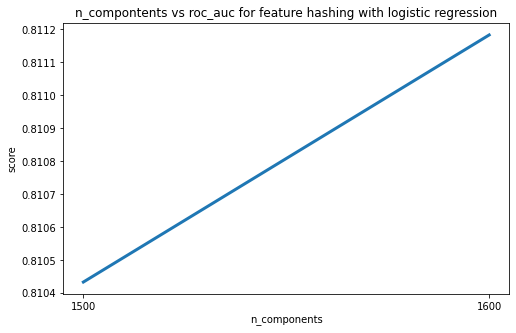

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(n_components_list_str, fh_logit_scores, linewidth=3)
plt.title('n_compontents vs roc_auc for feature hashing with logistic regression')
plt.xlabel('n_components')
plt.ylabel('score')
plt.show()

In [14]:
fh_logit_scores

[0.8104329659234666, 0.8111834285642642]

## Test dataset benchmarking

In [ ]:
%%time
hashing_enc = ce.HashingEncoder(cols=columns, n_components=1700).fit(X_train, y_train)
X_train_hashing = hashing_enc.transform(X_train.reset_index(drop=True))

In [ ]:
%%time
idee_test = pd.read_csv('test_identity.csv')
transaction_test = pd.read_csv('test_transaction.csv')
objects_test = pipeline(idee_test,transaction_test)
del idee_test, transaction_test

In [ ]:
%%time
objects_test.head()

In [ ]:
%%time
X2 = objects_test.drop(columns='isFraud')
y2 = objects_test['isFraud'].astype('int')

columns = X.columns.to_list()

under = RandomUnderSampler() 
over = RandomOverSampler()

X_ros, y_ros = over.fit_resample(X, y)
X_cs, y_cs = under.fit_resample(X_ros, y_ros)
del X_ros, y_ros

In [ ]:
%%time
X2_hashed = hashing_enc.transform(X_cs.reset_index(drop=True))

In [ ]:
%%time
score = get_score(logit, X_train_hashing, y_train, X2_hashed, y_cs)
score